In [33]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [34]:
url = 'https://www.worldometers.info/coronavirus/'
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
_dict = {}

In [35]:
page = requests.get(url)
soup = BeautifulSoup(page.content)

<!DOCTYPE html>
<!--[if IE 8]> <html lang="en" class="ie8"> <![endif]-->
<!--[if IE 9]> <html lang="en" class="ie9"> <![endif]-->
<!--[if !IE]><!-->
<html lang="en">
 <!--<![endif]-->
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <title>
   Coronavirus Update (Live): 237,125 Cases and 9,835 Deaths from COVID-19 Virus Outbreak - Worldometer
  </title>
  <meta content="Live statistics and coronavirus news tracking the number of confirmed cases, recovered patients, and death toll by country due to the COVID 19 coronavirus from Wuhan, China. Coronavirus counter with new cases, historical data, and info. Daily charts, graphs, news and updates" name="description"/>
  <!-- Favicon -->
  <link href="/favicon/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
  <link href="/favicon/apple-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/>
  <link href="/favicon/apple-ico
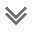

In [36]:
print(soup.prettify())

In [37]:
for _tr_list in soup.tbody.find_all('tr'):
    _td_list = _tr_list.find_all('td')
    for i, _td in enumerate(_td_list):        
        # Recuperar el nombre del pais cuando es un enlace
        if i%9 == 0:
            _a = _td.find('a')
                # Recuperar el nombre del pais cuando es un enlace
            if _a:
                country_name = _a['href'].split('/')[1]
            else:
                _span = _td.find('span')
                if _span:
                    # Recuperar el nombre del cuando ocupa dos filas
                    country_name = _span.contents[0]
                else:
                     # Recuperar el nombre del pais cuando no es un enlace
                    country_name = _td.contents[0]
            if country_name:
                country_name = country_name.strip()
                if country_name not in list(_dict.keys()):
                    _dict[country_name] = {} 
                _dict[country_name][now] = []
        # Recuperar los datos del pais
        else:
            if len(_td.contents) > 0:
                # Limipiar el dato de cualquier símbolo para poder convertirlo en un valor numérico
                data = _td.contents[0].replace('+','').replace(',','').strip()
                if data:
                    _dict[country_name][now].append(float(data))
                else:
                    _dict[country_name][now].append(0)
            else:
                _dict[country_name][now].append(0)

In [38]:
# https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
df = pd.concat({k: pd.DataFrame(v).T for k, v in _dict.items()}, axis=0)
df.columns = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_recovered', 'active_cases', 'servious_critical', 'total_cases_1M_pop']
df.index.names = ['country', 'timestamp']
display(df.head())

,,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop
country,timestamp,,,,,,,,
Afghanistan,2020-03-19 19:23:06,22.0,0.0,0.0,0.0,1.0,21.0,0.0,0.6
Albania,2020-03-19 19:23:06,64.0,5.0,2.0,0.0,0.0,62.0,2.0,22.0
Algeria,2020-03-19 19:23:06,90.0,15.0,9.0,2.0,32.0,49.0,0.0,2.0
Andorra,2020-03-19 19:23:06,53.0,0.0,0.0,0.0,1.0,52.0,0.0,686.0
Antigua and Barbuda,2020-03-19 19:23:06,1.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0


In [39]:
df.loc['spain']

,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop
timestamp,,,,,,,,
2020-03-19 19:23:06,17395.0,2626.0,803.0,165.0,1107.0,15485.0,800.0,372.0


In [26]:
#df.to_csv('covid-19_2020.csv', index=True)
#df.to_csv('covid-19_2020.csv', mode='a', header=False, index=True) 

In [41]:
df = pd.read_csv('covid-19_2020.csv')

In [42]:
df.head()

,country,timestamp,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop
0,Afghanistan,2020-03-19 19:12:43,22.0,0.0,0.0,0.0,1.0,21.0,0.0,0.6
1,Albania,2020-03-19 19:12:43,64.0,5.0,2.0,0.0,0.0,62.0,2.0,22.0
2,Algeria,2020-03-19 19:12:43,90.0,15.0,9.0,2.0,32.0,49.0,0.0,2.0
3,Andorra,2020-03-19 19:12:43,53.0,0.0,0.0,0.0,1.0,52.0,0.0,686.0
4,Antigua and Barbuda,2020-03-19 19:12:43,1.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0


In [43]:
plt.plot('xlabel', 'ylabel', data=obj)(df['spain'])

NameError: name 'obj' is not defined

In [46]:
# Se muestra el número de árboles plantados por tipo y año

# Se representan gráficamente los resultados
# https://seaborn.pydata.org/tutorial/categorical.html
plot = sns.catplot("ANY", kind="count", 
                   hue = "country", palette="ch:.25", height=10, data=df)

ValueError: Could not interpret input 'ANY'